# Possible Perception of Failure following Net Zero

In [1]:
# __authors__: Noah Diffenbaugh, Elizabeth Barnes and Patrick Keys
# __date__: June 1, 2022

In [2]:
%matplotlib inline
%load_ext autotime

import importlib as imp
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import datetime
from icecream import ic

import data_processing, plots, experiment_settings

import cartopy as ct
import palettable
from matplotlib.colors import ListedColormap
import matplotlib as mpl

savefig_dpi = 300
np.warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
import warnings
warnings.filterwarnings("ignore")

FS = 10
plt.rc('text',usetex=True)
plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']}) 
plt.rc('savefig',facecolor='white')
plt.rc('axes',facecolor='white')
plt.rc('axes',labelcolor='dimgrey')
plt.rc('axes',labelcolor='dimgrey')
plt.rc('xtick',color='dimgrey')
plt.rc('ytick',color='dimgrey')
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["figure.dpi"] = 150

map_proj = ct.crs.EqualEarth(central_longitude = 0.)

time: 574 ms (started: 2023-01-16 07:37:36 -07:00)


In [3]:
EXP_NAME = "exp34"
settings = experiment_settings.get_settings(EXP_NAME)
TREND_YEARS_NETZERO = (settings["focus_year"],settings["focus_year"]+(settings["time_horizon"]-1))
TREND_YEARS_PREZERO = (settings["focus_year"]-settings["time_horizon"],settings["focus_year"]-1)
print(TREND_YEARS_PREZERO)

(1995, 2024)
time: 335 µs (started: 2023-01-16 07:37:36 -07:00)


In [4]:
YEAR_RANGE = (2015,2100)
DATA_DIRECTORY = 'data/'
FIGURE_DIRECTORY = 'figures/'
SHAPE_DIRECTORY = 'shapefiles/'
POP_DIRECTORY = DATA_DIRECTORY + "popdynamics-1-8th-pop-base-year-projection-ssp-2000-2100-rev01-proj-ssp1-netcdf/SSP1/Total/NetCDF/"

time: 6.25 ms (started: 2023-01-16 07:37:36 -07:00)


# Get the data

In [5]:
imp.reload(data_processing)
# mask = data_processing.get_land_mask(DATA_DIRECTORY + 'sftlf_fx_CESM2-WACCM_historical_r1i1p1f1_gn.nc', var="sftlf")
da_all, filenames = data_processing.get_data(DATA_DIRECTORY, 
                                             YEAR_RANGE,
                                             N_MEMBERS = settings["n_members"], 
                                             filenames=settings["filenames"],
                                             ssp=settings["ssp"], 
                                             time_horizon=settings["time_horizon"]
                                            )

if settings["exp_name"]=="exp0":
    da_all_ssp126, __ = data_processing.get_data(DATA_DIRECTORY, 
                                                 YEAR_RANGE,
                                                 N_MEMBERS = settings["n_members"], 
                                                 filenames=settings["filenames"],
                                                 ssp="126", 
                                                 time_horizon=settings["time_horizon"]
                                                )   

tas_Amon_historical_ssp126_CanESM5_r1-10_ncecat_ann_mean_2pt5degree.nc
tas_Amon_historical_ssp126_MIROC6_r1-10_ncecat_ann_mean_2pt5degree.nc
tas_Amon_historical_ssp126_ACCESS-ESM1-5_r1-10_ncecat_ann_mean_2pt5degree.nc
tas_Amon_historical_ssp126_UKESM1-0-LL_r1-10_ncecat_ann_mean_2pt5degree.nc
tas_Amon_historical_ssp126_MIROC-ES2L_r1-10_ncecat_ann_mean_2pt5degree.nc
tas_Amon_historical_ssp126_CNRM-CM6-1_r1-5_ncecat_ann_mean_2pt5degree.nc
tas_Amon_historical_ssp126_CNRM-ESM2-1_r1-5_ncecat_ann_mean_2pt5degree.nc
tas_Amon_historical_ssp126_GISS-E2-1-G_r1-5_ncecat_ann_mean_2pt5degree.nc
tas_Amon_historical_ssp126_IPSL-CM6A-LR_r1-5_ncecat_ann_mean_2pt5degree.nc
tas_Amon_historical_ssp126_MRI-ESM2-0_r1-5_ncecat_ann_mean_2pt5degree.nc
da_all.shape = (50, 86, 72, 144)
time: 520 ms (started: 2023-01-16 07:37:36 -07:00)


In [6]:
imp.reload(data_processing)

# --------------------------------
# PRE-ZERO trends
da_mean_trends_all_prezero = data_processing.compute_trends(da_all.mean("member"), YEAR_RANGE[0], settings["focus_year"]-1)
ic(da_mean_trends_all_prezero.shape)

da_trends_prezero = data_processing.compute_trends(da_all, TREND_YEARS_PREZERO[0], TREND_YEARS_PREZERO[1])
ic(da_trends_prezero.shape)

# --------------------------------
# NETZERO trends
da_mean_trends_all_netzero = data_processing.compute_trends(da_all.mean("member"), TREND_YEARS_NETZERO[0], YEAR_RANGE[1])
ic(da_mean_trends_all_netzero.shape)

da_trends_netzero = data_processing.compute_trends(da_all, TREND_YEARS_NETZERO[0], TREND_YEARS_NETZERO[1])
ic(da_trends_netzero.shape)


computing trends for 2015-2024


ic| da_mean_trends_all_prezero.shape: (2, 72, 144)
ic| da_trends_prezero.shape: (2, 50, 72, 144)


computing trends for 1995-2024


ic| da_mean_trends_all_netzero.shape: (2, 72, 144)
ic| da_trends_netzero.shape: (2, 50, 72, 144)


computing trends for 2025-2100
computing trends for 2025-2054


(2, 50, 72, 144)

time: 640 ms (started: 2023-01-16 07:37:37 -07:00)


# Perceived Failure

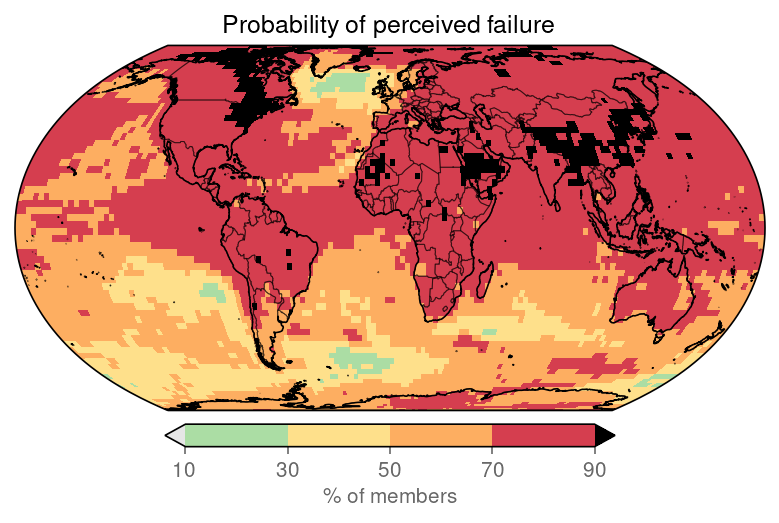

time: 12.5 s (started: 2023-01-16 07:37:37 -07:00)


In [7]:
imp.reload(plots)

#-----------------------------------------------------------------    

fig = plt.figure(figsize=(5.0*1,3.75*1))
MASK_BOOL = False

#-----------------------------------------------------------------
# PERCEIVED FAILURES
ax = fig.add_subplot(1,1,1,projection=map_proj)
cmap = palettable.colorbrewer.diverging.Spectral_8_r.mpl_colors
cmap = np.delete(cmap,(0,1,3,6),0)
cmap = ListedColormap(cmap)

da_plot = da_trends_netzero[0,:,:,:].squeeze()
da_plot_prezero = da_trends_prezero[0,:,:,:].squeeze()

da_quad_1 = xr.where((da_plot_prezero>=settings["warming_cutoff"]) & (da_plot>=settings["warming_cutoff"]), 1, 0) 
da_quad_2 = xr.where((da_plot_prezero<settings["warming_cutoff"]) & (da_plot>=settings["warming_cutoff"]), 1, 0) 
da_quad_3 = xr.where((da_plot_prezero<settings["warming_cutoff"]) & (da_plot<settings["warming_cutoff"]), 1, 0) 
da_quad_4 = xr.where((da_plot_prezero>=settings["warming_cutoff"]) & (da_plot<settings["warming_cutoff"]), 1, 0) 
da_quad = (da_quad_1 + da_quad_2).sum("member")/len(da_plot["member"].values)

#---------------------
if MASK_BOOL:
    da_plot_member = da_quad * mask
else:
    da_plot_member = da_quad
da_plot_member = da_plot_member*100

cb,p = plots.drawOnGlobe(ax, 
                  map_proj, 
                  data=da_plot_member, 
                  lats=da_plot_member["lat"],
                  lons=da_plot_member["lon"],
                  cmap=cmap,
                  vmin=-5,
                  vmax= 105, 
                  inc=None, 
                  cbarBool=False, 
                  contourMap=[], 
                  contourVals = [], 
                  fastBool=True, 
                  extent='both',
                 )   

p.set_clim(10,90)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
p.cmap.set_over('k')
p.cmap.set_under('.9')
cbar = plt.colorbar(p,ax=ax,label='\% of members',ticks=np.arange(10,90+20,20), extend="both",orientation='horizontal',pad=.025,shrink=.6)
cbar.ax.set_xticklabels(np.arange(10,90+20,20)) 

ax.set_title('Probability of perceived failure')     

#-----------------------------------------------------------------
# plt.tight_layout()
fig.tight_layout(pad=0., h_pad=0, w_pad=0)
plots.savefig(FIGURE_DIRECTORY + EXP_NAME + '_perceived_failure')
plt.show()

In [8]:
error('here')

NameError: name 'error' is not defined

time: 245 ms (started: 2023-01-16 07:37:50 -07:00)


# Perceived Failures and Maximum temperature exceedances

In [ ]:
imp.reload(plots)
for baseline_def in ('time_horizon','all_past'):

    da_maxT = None
    da_maxPR = None
    n_maxT = 0
    n_maxPR = 0        
    
    if EXP_NAME=='exp0':
        if baseline_def=='all_past':
            maxfile = 'tas_day_8GCMs_ssp119_enssub_nrun3_20560101_20651231_20150101_20551231_max.nc'
            da_maxT = xr.open_dataarray(DATA_DIRECTORY + maxfile)
            n_maxT = 8

            maxfile = 'pr_day_7GCMs_ssp119_enssub_nrun5_20560101_20651231_20150101_20551231_max.nc'
            da_maxPR = xr.open_dataarray(DATA_DIRECTORY + maxfile)
            n_maxT = 7
            
            p_border_clr = 'k'
            t_border_clr = 'k'

        elif baseline_def=='time_horizon':
            maxfile = 'tas_day_8GCMs_ssp119_enssub_nrun3_20560101_20651231_20460101_20551231_max.nc'
            da_maxT = xr.open_dataarray(DATA_DIRECTORY + maxfile)
            n_maxT = 8

            maxfile = 'pr_day_7GCMs_ssp119_enssub_nrun5_20560101_20651231_20460101_20551231_max.nc'
            da_maxPR = xr.open_dataarray(DATA_DIRECTORY + maxfile)
            n_maxT = 7 
            
            p_border_clr = 'w' 
            t_border_clr = 'k'
            
    elif EXP_NAME=='exp1':
        if baseline_def=='all_past':
            maxfile = 'tas_day_8GCMs_ssp119_enssub_nrun3_20250101_20341231_20150101_20241231_max.nc'
            da_maxT = xr.open_dataarray(DATA_DIRECTORY + maxfile)
            n_maxT = 8

            maxfile = 'pr_day_7GCMs_ssp119_enssub_nrun5_20250101_20341231_20150101_20241231_max.nc'
            da_maxPR = xr.open_dataarray(DATA_DIRECTORY + maxfile)
            n_maxT = 7  
            
            p_border_clr = 'w'
            t_border_clr = 'w'
            
        elif baseline_def=='time_horizon':
            maxfile = 'tas_day_8GCMs_ssp119_enssub_nrun3_20250101_20341231_20150101_20241231_max.nc'
            da_maxT = xr.open_dataarray(DATA_DIRECTORY + maxfile)
            n_maxT = 8

            maxfile = 'pr_day_7GCMs_ssp119_enssub_nrun5_20250101_20341231_20150101_20241231_max.nc'
            da_maxPR = xr.open_dataarray(DATA_DIRECTORY + maxfile)
            n_maxT = 7  
            
            p_border_clr = 'w'
            t_border_clr = 'w'
    else:
        raise NotImplementedError
    #-----------------------------------------------------------------    
    
    fig = plt.figure(figsize=(5.0*1,3.75*3))
    MASK_BOOL = False

    #-----------------------------------------------------------------
    # ANNUAL TEMP MAXIMUM EXCEEDANCES
    ax = fig.add_subplot(3,1,1,projection=map_proj)
    cmap = ListedColormap(palettable.colorbrewer.sequential.OrRd_9.mpl_colors)
    cmap = cmap.colors
    cmap = np.insert(cmap, 0, [[.9, .9, .9,]],axis=0)
    cmap = np.append(cmap, [[0., 0., 0.,]],axis=0)
    cmap = cmap[(2,4,6,8),:]
    cmap = ListedColormap(cmap)

    max_netzero_plot = None
    for PLOT_MEMBER in range(da_trends_netzero.shape[1]):
        da_plot = da_all[PLOT_MEMBER,:,:,:].squeeze()

        if baseline_def == 'all_past':
            iyears = np.where(((da_plot["time"]<=TREND_YEARS_PREZERO[1])))[0]
        elif baseline_def == 'time_horizon':
            iyears = np.where(((da_plot["time"]>=TREND_YEARS_PREZERO[0])) & (da_plot["time"]<=TREND_YEARS_PREZERO[1]))[0]
        else:
            raise NotImplementedError
        
        # print('years for maximum = ' + str(da_plot["time"][iyears]))
        max_temps = da_plot[iyears,:,:].max("time")

        iyears = np.where(((da_plot["time"]>=TREND_YEARS_NETZERO[0])) & (da_plot["time"]<=TREND_YEARS_NETZERO[1]))[0]
        # print(da_plot["time"][iyears])
        max_netzero = xr.where(da_plot[iyears,:,:]>max_temps,1.0,0.0)
        max_netzero = max_netzero.max("time")
        if max_netzero_plot is None:
            max_netzero_plot = max_netzero
        else:
            max_netzero_plot = max_netzero_plot + max_netzero

    cb,p = plots.drawOnGlobe(ax, 
                      map_proj,
                      # data=max_netzero_plot*mask/(np.shape(da_trends_netzero)[1])*100,
                      data=max_netzero_plot/(np.shape(da_trends_netzero)[1])*100,
                      lats=da_plot["lat"],
                      lons=da_plot["lon"],
                      cmap=cmap,
                      vmin= -5, 
                      vmax= 105, 
                      inc=None, 
                      cbarBool=False, 
                      contourMap=[], 
                      contourVals = [], 
                      fastBool=True, 
                      extent='both',
                      border_color=t_border_clr,
                     ) 
    p.set_clim(10,90)
    p.cmap.set_under('.9')
    p.cmap.set_over('k')
    ax = plt.gca()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False) 
    cbar = plt.colorbar(p,ax=ax,label='\% of members',ticks=np.arange(0,110,10), extend='both',orientation='horizontal',pad=.025,shrink=.6)
    cbar.ax.set_xticklabels(np.arange(0,110,10)) 
    ax.set_title('(A) Probability of annual temperature extremes')     


    #-----------------------------------------------------------------
    # MAXIMUM TEMPERATURE EXCEEDANCES
    ax = fig.add_subplot(3,1,2,projection=map_proj)
    cmap = ListedColormap(palettable.colorbrewer.sequential.OrRd_9.mpl_colors)
    cmap = cmap.colors
    cmap = np.insert(cmap, 0, [[.9, .9, .9,]],axis=0)
    cmap = np.append(cmap, [[0., 0., 0.,]],axis=0)
    cmap = cmap[(2,4,6,8),:]
    cmap = ListedColormap(cmap)
    cb,p = plots.drawOnGlobe(ax, 
                      map_proj,
                      data=da_maxT*100,
                      lats=da_maxT["lat"],
                      lons=da_maxT["lon"],
                      cmap=cmap,
                      vmin= -5, 
                      vmax= 105, 
                      inc=None, 
                      cbarBool=False, 
                      contourMap=[], 
                      contourVals = [], 
                      fastBool=True, 
                      extent='both',
                      border_color=t_border_clr,
                     ) 
    p.set_clim(10,90)
    p.cmap.set_under('.9')
    p.cmap.set_over('k')
    ax = plt.gca()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False) 
    cbar = plt.colorbar(p,ax=ax,label='\% of members',ticks=np.arange(0,110,10), extend='both',orientation='horizontal',pad=.025,shrink=.6)
    cbar.ax.set_xticklabels(np.arange(0,110,10)) 
    ax.set_title('(B) Probability of daily temperature extremes')     

    #-----------------------------------------------------------------
    # MAXIMUM PRECIPITATION EXCEEDANCES
    ax = fig.add_subplot(3,1,3,projection=map_proj)
    cmap = ListedColormap(palettable.colorbrewer.sequential.BuPu_9.mpl_colors)
    cmap = cmap.colors
    cmap = np.insert(cmap, 0, [[.9, .9, .9,]],axis=0)
    cmap = np.append(cmap, [[0., 0., 0.,]],axis=0)
    cmap = cmap[(2,4,6,8),:]
    cmap = ListedColormap(cmap)
    cb,p = plots.drawOnGlobe(ax, 
                      map_proj,
                      data=da_maxPR*100,
                      lats=da_maxPR["lat"],
                      lons=da_maxPR["lon"],
                      cmap=cmap,
                      vmin= -5, 
                      vmax= 105, 
                      inc=None, 
                      cbarBool=False, 
                      contourMap=[], 
                      contourVals = [], 
                      fastBool=True, 
                      extent='both',
                      border_color=p_border_clr,
                     ) 
    p.set_clim(10,90)
    p.cmap.set_under('.9')
    p.cmap.set_over('k')
    ax = plt.gca()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False) 
    cbar = plt.colorbar(p,ax=ax,label='\% of members',ticks=np.arange(0,110,10), extend='both',orientation='horizontal',pad=.025,shrink=.6)
    cbar.ax.set_xticklabels(np.arange(0,110,10)) 
    ax.set_title('(C) Probability of daily precipitation extremes')     

    #-----------------------------------------------------------------
    # plt.tight_layout()
    fig.tight_layout(pad=0., h_pad=-4, w_pad=0)
    plots.savefig(FIGURE_DIRECTORY + EXP_NAME + '_maxima_exceedance_' + baseline_def)
    plt.show()

# Figure 1

In [ ]:
def plot_timeseries(netzero_year,color='teal'):
    plt.axvspan(netzero_year, 2100, alpha=0.1, color=color)   

    plt.plot(global_mean_temp["time"]+.5,global_mean_temp.T, color='dimgray',linewidth=.5,alpha=.25)
    plt.plot(global_mean_temp["time"]+.5,np.mean(global_mean_temp,0), color='k',linewidth=4., alpha=.75)

    plots.format_spines(plt.gca())
    ymin, ymax = plt.gca().get_ylim()
    plt.xticks(np.arange(2010,2100,20),np.arange(2010,2100,20))
    plt.yticks(np.arange(-10.0,10.0,.5),np.round(np.arange(-10.0,10.0,.5),2))
    plt.ylabel('temperature anomalies (C)\nfrom 2015-2024')
    # plt.xlabel('year')    
    plt.xlim(2010,2100)
    plt.ylim(-1.5,2.0)

    plt.text(netzero_year+.5,-1.45,'Net Zero',color=color)    

In [ ]:
imp.reload(plots)
PLOT_MEMBER = settings["plot_member"]
MULT_FACTOR = 10
#------------------------
# fig = plt.figure(figsize=(13,3*3))
fig = plt.figure(figsize=(5.0*1.5*2,3.75*1.2*3))
vbound = 0.2*MULT_FACTOR
#------------------------
# Plot time series

if settings["exp_name"]=="exp0":   
    spec = fig.add_gridspec(ncols=8, nrows=3, height_ratios=[.5,1,1], width_ratios=[.25,1,1,1,1,1,1,.25])    
    
    ax = fig.add_subplot(spec[0,1:3])
    plots.plot_emissions(ax)
    plt.xticks(np.arange(2010,2100,20),np.arange(2010,2100,20))
    plt.xlim(2010,2100)
    plt.title('(A) Anthropogenic CO$_2$ emissions')   
    
    ax = fig.add_subplot(spec[0,5:7])
    global_mean_temp = data_processing.compute_global_mean(da_all_ssp126)    
    plot_timeseries(2076,color='tab:pink')    
    # ax.set_ylabel('')
    # ax.set_yticklabels('')
    ax.set_title('(C) SSP1-2.6')   
    
    ax = fig.add_subplot(spec[0,3:5])
    global_mean_temp = data_processing.compute_global_mean(da_all)    
    plot_timeseries(TREND_YEARS_NETZERO[0],color='teal')
    ax.set_title('(B) SSP1-1.9')   

    
    
    # ax_both = fig.add_subplot(spec[0,:])
    # ax_both.axis('off')
    # ax_both.set_title('(A) Global mean temperature')
    
else:
    spec = fig.add_gridspec(ncols=4, nrows=3, height_ratios=[.65,1,1], width_ratios=[1,.6,.6,1])    
    ax = fig.add_subplot(spec[0,1:3])
    global_mean_temp = data_processing.compute_global_mean(da_all)
    plot_timeseries(TREND_YEARS_NETZERO[0])
    ax.set_title('(A) Global mean temperature')

#------------------------


for MASK_BOOL in (False,):
    for data_type in ("all","member"):
        for start_year in (2025, 2035):

            if data_type=="member":
                if start_year == 2025:            
                    da_plot = da_trends_prezero[0,PLOT_MEMBER,:,:].squeeze()  
                    title_text = "(F) SSP1-1.9 member \#" + str(PLOT_MEMBER+1) + " trends, " + str(TREND_YEARS_PREZERO[0]) + "-" + str(TREND_YEARS_PREZERO[1])               
                    specs = (2,0)
                elif start_year == 2035:
                    da_plot = da_trends_netzero[0,PLOT_MEMBER,:,:].squeeze()
                    title_text = "(G) SSP1-1.9 member \#" + str(PLOT_MEMBER+1) + " trends, " + str(TREND_YEARS_NETZERO[0]) + "-" + str(TREND_YEARS_NETZERO[1])               
                    specs = (2,4)
            elif data_type=="all":
                if start_year == 2025:            
                    da_plot = da_mean_trends_all_prezero[0,:,:].squeeze()            
                    title_text = "(D) SSP1-1.9 ensemble mean trends, " + "2015-" + str(settings["focus_year"]-1)  
                    specs = (1,0)
                elif start_year == 2035:
                    da_plot = da_mean_trends_all_netzero[0,:,:].squeeze()
                    title_text = "(E) SSP1-1.9 ensemble mean trends, " + str(settings["focus_year"]) + "-2100"
                    specs = (1,4)


            if MASK_BOOL:
                da_plot_member = da_plot * mask
                da_positive_trends = np.ceil(np.abs(da_plot_member.where(da_plot_member>=settings["warming_cutoff"],0.,drop=False)))
                da_positive_trends = da_positive_trends * mask
            else:
                da_plot_member = da_plot
                da_positive_trends = np.ceil(np.abs(da_plot_member.where(da_plot_member>=settings["warming_cutoff"],0.,drop=False)))        
            frac = data_processing.compute_global_mean( da_positive_trends )

            ax = fig.add_subplot(spec[specs[0],specs[1]:specs[1]+4],projection=map_proj)
            cb,image = plots.drawOnGlobe(ax, 
                              map_proj, 
                              data=da_plot_member*MULT_FACTOR, 
                              lats=da_plot_member["lat"],
                              lons=da_plot_member["lon"],
                              cmap='RdBu_r',
                              vmin= -vbound, 
                              vmax= vbound, 
                              inc=None, 
                              cbarBool=False, 
                              contourMap=[], 
                              contourVals = [], 
                              fastBool=True, 
                              extent='both',
                             )   
            ax.text(0,-50,str(int((100*frac).round())) + '\% of area warming',color='black', fontsize=10, transform=ct.crs.PlateCarree())

            image.set_clim(-vbound,vbound)
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False) 
            ax.set_title(title_text)

    fig.tight_layout(pad=1., h_pad=0., w_pad=1)
    # set colorbar        
    axs = fig.axes
    bounds = np.round(np.arange(-.2,.29,.1),3)*MULT_FACTOR
    cb = fig.colorbar(image, ax=axs, 
                      shrink=0.3, 
                      ticks=bounds,
                      location='bottom',
                      pad=.025,
                      extend='both',
                      label='degrees C per decade',
                     )
    cb.set_ticklabels(['-2', '-1', '0', '1', '2'])
    
    # plt.tight_layout() 
    plots.savefig(FIGURE_DIRECTORY + EXP_NAME + '_five_panel_trends_member' + str(PLOT_MEMBER))
    plt.show()

# Perceived Failures Frequency

In [ ]:
MASK_BOOL = False

cmap = ListedColormap(palettable.colorbrewer.qualitative.Paired_11.mpl_colors)
cmap = plots.get_qual_cmap()
cmap = palettable.colorbrewer.diverging.Spectral_8_r.mpl_colors
cmap = np.delete(cmap,(0,1,3,6),0)
cmap = ListedColormap(cmap)

fig = plt.figure(figsize=(9,3*2))

da_plot = da_trends_netzero[0,:,:,:].squeeze()
da_plot_prezero = da_trends_prezero[0,:,:,:].squeeze()
da_quad_check = None
for iq,quad in enumerate((2,1,3,4)):

    if(quad==1):
        da_quad = xr.where((da_plot_prezero>=settings["warming_cutoff"]) & (da_plot>=settings["warming_cutoff"]), 1, 0) 
        text_title = "(B) Continued Warming"
    elif(quad==2):
        da_quad = xr.where((da_plot_prezero<settings["warming_cutoff"]) & (da_plot>=settings["warming_cutoff"]), 1, 0) 
        text_title = "(A) Rebound Warming"        
    elif(quad==3):
        da_quad = xr.where((da_plot_prezero<settings["warming_cutoff"]) & (da_plot<settings["warming_cutoff"]), 1, 0) 
        text_title = "(C) Stabilization"                
    elif(quad==4):
        da_quad = xr.where((da_plot_prezero>=settings["warming_cutoff"]) & (da_plot<settings["warming_cutoff"]), 1, 0) 
        text_title = "(D) Recovery"                
    da_quad = da_quad.mean("member")
    if da_quad_check is None:
        da_quad_check = da_quad
    else:
        da_quad_check = da_quad_check + da_quad
    #---------------------
    if MASK_BOOL:
        da_plot_member = da_quad * mask
    else:
        da_plot_member = da_quad
    
    ax = fig.add_subplot(2,2,iq+1,projection=map_proj)
    cb,p = plots.drawOnGlobe(ax, 
                      map_proj, 
                      data=da_plot_member*100, 
                      lats=da_plot_member["lat"],
                      lons=da_plot_member["lon"],
                      cmap=cmap,
                      vmin= -5, 
                      vmax= 105, 
                      inc=None, 
                      cbarBool=False, 
                      contourMap=[], 
                      contourVals = [], 
                      fastBool=True, 
                      extent='both',
                     )   
    p.set_clim(10,90)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    p.cmap.set_over('k')
    p.cmap.set_under('.9')
    cbar = plt.colorbar(p,ax=ax,label='\% of members',ticks=np.arange(10,90+20,20), extend="both",orientation='horizontal',pad=.025,shrink=.5)
    cbar.ax.set_xticklabels(np.arange(10,90+20,20)) 
    
    # p.set_clim(-5,105)
    # ax.xaxis.set_visible(False)
    # ax.yaxis.set_visible(False) 
    # plt.colorbar(p,ax=ax,label='\% of members')
    
    ax.set_title(text_title)
    
plt.tight_layout()
plots.savefig(FIGURE_DIRECTORY + EXP_NAME + '_quadrant_frequencies')
plt.show()

# Population and GDP figures

In [ ]:
#---------------------------------------------------
# GET POPULATION
#---------------------------------------------------
# processing the raw population data and regrid it
# imp.reload(data_processing)
# for decade in (2020,2030,2040,2050,2060,2070,2080,2090):
#     da_pop_regrid = data_processing.get_population(POP_DIRECTORY + "ssp1_" + str(decade) + ".nc", da_all)
#     da_pop_regrid.to_netcdf(DATA_DIRECTORY + '/ssp1_' + str(decade) + '_2.5x2.5.nc')

#---------------------------------------------------
# GET GDP
#---------------------------------------------------
# [m1] conda install -c conda-forge geopandas pygeos regionmask
# import geopandas as gpd
# import regionmask

# SHAPE_DIRECTORY = 'shapefiles/'
# regs_shp = gpd.read_file(SHAPE_DIRECTORY + 'ne_10m_admin_0_countries.shp')  

# mask_country = regionmask.mask_geopandas(regs_shp, np.arange(0,360,.1), np.arange(-90,90,.1))
# mask_country.to_netcdf(SHAPE_DIRECTORY + 'countries_10m_tenthDegreeGrid.nc')

# plt.imshow(mask_country,cmap="Accent")
# plt.colorbar()
# plt.show()
# print(np.unique(mask_country),len(np.unique(mask_country)))

# mask_country = regionmask.mask_geopandas(regs_shp, da_pop_regrid.lon, da_pop_regrid.lat)
# mask_country.to_netcdf(SHAPE_DIRECTORY + 'countries_10m_2.5x2.5.nc')

# plt.imshow(mask_country,cmap="Accent")
# plt.colorbar()
# plt.show()
# print(np.unique(mask_country),len(np.unique(mask_country)))

da_pop_regrid = xr.load_dataarray(DATA_DIRECTORY + '/ssp1_' + str(settings["pop_year"]) + '_2.5x2.5.nc')
gdp, regs_shp, country_mask = data_processing.get_gdp(SHAPE_DIRECTORY, DATA_DIRECTORY, settings["gdp_year"])


## GDP ONLY

In [ ]:
colors = ('#D95980','#E1A730','#A9C961','#A7C7E7',) 
colors_text = ('#d03262','#c9901d','#84a638','#5895d1') # https://pinetools.com/darken-color
if settings["ssp"]=="119":
    clr_index = 1
else:
    clr_index = 2    
    
#------------------------------------------------------------------------------------
# PLOT PROBABILITY vs GDP
fig = plt.figure(figsize=(5.0*1.25,3.75),)
ax1 = fig.add_subplot(1,1,1)

FAILURE_FRAC = .1
SCALING = 1e6
np.random.seed(15)

da_plot = da_trends_netzero[0,:,:,:].squeeze()
da_plot_prezero = da_trends_prezero[0,:,:,:].squeeze()

da_quad_1 = xr.where((da_plot_prezero>=settings["warming_cutoff"]) & (da_plot>=settings["warming_cutoff"]), 1, 0) 
da_quad_2 = xr.where((da_plot_prezero<settings["warming_cutoff"]) & (da_plot>=settings["warming_cutoff"]), 1, 0) 
da_quad_3 = xr.where((da_plot_prezero<settings["warming_cutoff"]) & (da_plot<settings["warming_cutoff"]), 1, 0) 
da_quad_4 = xr.where((da_plot_prezero>=settings["warming_cutoff"]) & (da_plot<settings["warming_cutoff"]), 1, 0) 
da_quad = (da_quad_1 + da_quad_2)
# da_quad = (da_quad_1 + da_quad_2).sum("member")/len(da_plot["member"].values)

gdp_matrix = np.zeros((gdp.shape[0],5))*np.nan
for icountry in np.arange(0,gdp.shape[0]):
    
    admin = gdp["Region"][icountry]
    gdp_matrix[icountry,0] = gdp[str(settings["gdp_year"])][icountry]

    try:
        i = regs_shp[regs_shp["ADM0_A3"]==admin].index.values[0]
    except:
        continue
    da_country = country_mask.where(country_mask==i,np.nan)*0.0+1.

    da_pop = da_country*da_pop_regrid
    gdp_matrix[icountry,2] = da_pop.sum(("lat","lon")).values

    gdp_matrix[icountry,3] = i
        
    for member in range(da_all.shape[0]):
        x = da_quad[member,:,:].sum(("lat","lon"))

        total_pop = da_pop.sum(("lat","lon"))
        failure_pop = ((da_pop*da_quad[member,:,:]).sum(("lat","lon")))/total_pop    
        gdp_matrix[icountry,4] = np.nansum((gdp_matrix[icountry,4],(da_pop*da_quad[member,:,:]).sum(("lat","lon")).values/da_all.shape[0]))
        # gdp_matrix[icountry,4] = np.nansum((gdp_matrix[icountry,4],failure_pop/da_all.shape[0]))
        # print(x.values,failure_pop.values,total_pop.values)    
    
        if failure_pop > FAILURE_FRAC:
            gdp_matrix[icountry,1] = np.nansum((gdp_matrix[icountry,1],1./da_trends_netzero.shape[1]))
            
        # scale per capita    
        # gdp_matrix[icountry,0] = gdp_matrix[icountry,0]/total_pop
            
            
# SCATTER PLOT            
ax1.scatter(gdp_matrix[:,0],gdp_matrix[:,1]*100,
            s=gdp_matrix[:,4]/(SCALING),
            # s=gdp_matrix[:,4]*500,
            alpha=.6,
            color=colors[clr_index],
           )
for i in range(gdp_matrix.shape[0]):
    if gdp_matrix[i,2]/SCALING > 120.:
        ax1.annotate(regs_shp["ADM0_A3"][gdp_matrix[i,3]], 
                     (gdp_matrix[i,0], gdp_matrix[i,1]*100*(1+np.random.randn(1)/15)),
                     fontsize=7,
                     color="k",
                     alpha=.75,
                    )
        # print(regs_shp["ADM0_A3"][gdp_matrix[i,3]])
        # print(gdp_matrix[i,:])
    
ax1.set_ylim(0,1.)
ax1.set_xlim(1,5e5)
ax1.set_xscale('log')
ax1.set_xlabel('GDP$|$PPP (billion US\$2005/yr)')
ax1.set_ylabel('\% of members')

# ax1.text(1,100,
#          str(TREND_YEARS_NETZERO[0]) + '-' + str(TREND_YEARS_NETZERO[0] + settings["time_horizon"] - 1),
#          color="k",
#          verticalalignment='top',
#          horizontalalignment='left')

#--------------------------------------------------------
# # population legend
fs = 6
ax1.scatter((2e5,2e5,2e5),(2,8,21),
            s=(10,100,1000,),
            alpha=.3,
            color='white', 
            edgecolor="gray",
           )        
ax1.annotate('10 million', (1.75e5,2),color='dimgray',fontsize=fs,horizontalalignment='right', verticalalignment='center')
ax1.annotate('100 million',(1.5e5,8),color='dimgray',fontsize=fs,horizontalalignment='right', verticalalignment='center')
ax1.annotate('1 billion',  (0.9e5,21),color='dimgray',fontsize=fs,horizontalalignment='right', verticalalignment='center')   
ax1.annotate('avg. population \nexperiencing\n perceived failure',  (2e5,36),color='dimgray',fontsize=fs,horizontalalignment='center', verticalalignment='center')   
#--------------------------------------------------------    

ax1.set_yticks(np.arange(0,120,20),np.arange(0,120,20))
# ax = plt.gca()
# labels = ax.get_xticklabels()
ax1.set_xticks((1e0,1e1,1e2,1e3,1e4,1e5,),('10$^0$','10$^1$','10$^2$','10$^3$','10$^4$','10$^5$',))
# ax1.set_title('(A) Countries experiencing perceived failure\n' + str(TREND_YEARS_NETZERO[0]) + '-' + str(TREND_YEARS_NETZERO[0] + settings["time_horizon"] - 1))
ax1.set_title('(A) Countries experiencing perceived failure')
plt.text(1,100,str(TREND_YEARS_NETZERO[0]) + '-' + str(TREND_YEARS_NETZERO[0] + settings["time_horizon"] - 1),verticalalignment='top',horizontalalignment='left',color=colors_text[clr_index],weight='bold')

plots.format_spines(ax1)

plots.savefig(FIGURE_DIRECTORY + EXP_NAME + '_gdp_scatter')


# GDP histograms

In [ ]:
PLOT_YEARS = (2025,2056,2076,2085)
fail_grid_fix = np.zeros((len(PLOT_YEARS), len(da_all["member"])))*np.nan

for iyear, year in enumerate(PLOT_YEARS):

    pop_file_year = int(np.round((year+settings["time_horizon"]/2)/10)*10)
    pop_filename = '/ssp1_' + str(pop_file_year) + '_2.5x2.5.nc'
    try:
        pop_year = xr.load_dataarray(DATA_DIRECTORY + pop_filename)
    except:
        print("out of data range.")
        break
    print(pop_filename)
    
    gdp, regs_shp, country_mask = data_processing.get_gdp(SHAPE_DIRECTORY, DATA_DIRECTORY, pop_file_year)
    
    print(year,year+(settings["time_horizon"]-1))
    hov_trends = data_processing.compute_trends(da_all, year, year+(settings["time_horizon"]-1))
    da_plot = hov_trends[0,:,:,:].squeeze()
    da_quad = xr.where((da_plot>=settings["warming_cutoff"]), 1, 0) 

    
    # country_stats = (country index, gdp of country, total country population, gdp weighted by population with failure)
    gdp_matrix = np.zeros((gdp.shape[0],da_all.shape[0],4))*np.nan
    for icountry in np.arange(0,gdp.shape[0]):

        admin = gdp["Region"][icountry]
        gdp_matrix[icountry,:,1] = gdp[str(pop_file_year)][icountry]

        try:
            i = regs_shp[regs_shp["ADM0_A3"]==admin].index.values[0]
        except:
            continue
        gdp_matrix[icountry,:,0] = i        
        da_country = country_mask.where(country_mask==i,np.nan)*0.0+1.

        da_pop = da_country*da_pop_regrid
        gdp_matrix[icountry,:,2] = da_pop.sum(("lat","lon")).values

        for member in range(da_all.shape[0]):
            x = da_quad[member,:,:].sum(("lat","lon"))

            total_pop = da_pop.sum(("lat","lon"))
            failure_pop = ((da_pop*da_quad[member,:,:]).sum(("lat","lon")))/total_pop    
            gdp_matrix[icountry,member,3] = failure_pop*gdp_matrix[icountry,0,1] # fraction of GDP
    
    fail_grid_fix[iyear,:] = np.nansum(gdp_matrix[:,:,3],axis=0) / gdp.sum().values[0]

    print(gdp_matrix.shape)
print(fail_grid_fix.shape)

In [ ]:
colors = ('#D95980','#E1A730','#A9C961','#A7C7E7',) 
colors_text = ('#d03262','#c9901d','#84a638','#5895d1') # https://pinetools.com/darken-color
x_plot = np.arange(0,1.1,.1)

fig = plt.figure(figsize=(5,2*len(PLOT_YEARS)))
for i,year in enumerate(PLOT_YEARS):
    
    ax = fig.add_subplot(len(PLOT_YEARS),1,i+1)
    
    heights, bins = np.histogram(fail_grid_fix[i,:],np.arange(0,1.1,.1))
    plt.bar((bins[:-1]+(bins[1]-bins[0])/2),100*heights/da_all.shape[0],color=colors[i],width=.09)
    plots.format_spines(ax)
    plt.xticks(np.arange(0,1.1,.10),np.round(np.arange(0,1.1,.10),2))
    plt.yticks(np.arange(0,120,10),np.arange(0,120,10))
    plt.ylim(0,40)
    plt.xlim(0,1.00)    
    plt.ylabel('\% of members') 
    plt.text(0,40,str(year)+'-'+str(year+settings["time_horizon"]-1),verticalalignment='top',horizontalalignment='left',color=colors_text[i],weight='bold')
    
plt.suptitle('(B) Fraction of global GDP\nexperiencing perceived failure')     
plt.xlabel('fraction of global GDP$|$PPP')

plt.tight_layout()
plots.savefig(FIGURE_DIRECTORY + EXP_NAME + '_gdp_histogram')
plt.show()


# Population histograms/PDFS

In [ ]:
YEAR_VEC      = np.arange(TREND_YEARS_NETZERO[0],YEAR_RANGE[1]+1)
fail_grid_fix = np.zeros((len(YEAR_VEC), len(da_all["member"])))*np.nan

for iyear, year in enumerate(YEAR_VEC):
    if year>=2090:
        break
    # print(year,int(np.round((year+settings["time_horizon"]/2)/10)*10))
    try:
        pop_year = xr.load_dataarray(DATA_DIRECTORY + '/ssp1_' + str(int(np.round((year+settings["time_horizon"]/2)/10)*10)) + '_2.5x2.5.nc')
    except:
        print("out of data range.")
        break

    hov_trends = data_processing.compute_trends(da_all, year, year+(settings["time_horizon"]-1))
    da_plot = hov_trends[0,:,:,:].squeeze()
    da_quad_1 = xr.where((da_plot>=settings["warming_cutoff"]), 1, 0) 
    da_quad = da_quad_1*pop_year.where(da_pop_regrid!=0, np.nan)
    fail_grid_fix[iyear,:] = 100*da_quad.sum(("lat","lon"))/pop_year.sum(("lat","lon"))


In [ ]:
colors = ('#D95980','#E1A730','#A9C961','#A7C7E7',) 
colors_text = ('#d03262','#c9901d','#84a638','#5895d1') # https://pinetools.com/darken-color
plot_years = (2025,2056,2076,2085)
x_plot = np.arange(0,101,1)

fig = plt.figure(figsize=(5,2*len(plot_years)))
count = 0
for i,year in enumerate(plot_years):
    
    j = np.where(YEAR_VEC==year)[0]
    if len(fail_grid_fix[j,:])==0:
        continue
    count = count + 1
    ax = fig.add_subplot(len(plot_years),1,count)        
    
    heights, bins = np.histogram(fail_grid_fix[j,:], np.arange(0,110,10))
    # plt.hist(h.T, np.arange(0,110,10),rwidth=.95,color=colors[i])
    plt.bar(bins[:-1]+(bins[1]-bins[0])/2,heights/da_all.shape[0]*100,width=9,color=colors[i])
    plots.format_spines(ax)
    plt.xticks(np.arange(0,110,10),np.arange(0,110,10))
    plt.yticks(np.arange(0,120,10),np.arange(0,120,10))
    plt.ylim(0,40)
    plt.xlim(0,100)    
    plt.ylabel('\% of members') 
    plt.text(0,40,str(year)+'-'+str(year+settings["time_horizon"]-1),verticalalignment='top',horizontalalignment='left',color=colors_text[i],weight='bold')
    
plt.suptitle('(C) Percent of global population\nexperiencing perceived failure')     
plt.xlabel('percent (\%)')

plt.tight_layout()
plots.savefig(FIGURE_DIRECTORY + EXP_NAME + '_population_histogram')
plt.show()


In [ ]:
error("here")

# Hovmoller over time horizon

In [ ]:
YEAR_VEC      = np.arange(TREND_YEARS_NETZERO[0],YEAR_RANGE[1]+1)
fail_grid     = np.zeros((len(YEAR_VEC),len(da_all["lat"])))*np.nan
fail_grid_fix = np.zeros((len(YEAR_VEC),len(da_all["lat"])))*np.nan

for iyear, year in enumerate(YEAR_VEC):
    if iyear > 0:
        hov_trends = data_processing.compute_trends(da_all, TREND_YEARS_NETZERO[0], year)
        da_plot = hov_trends[0,:,:,:].squeeze()
        da_quad_1 = xr.where((da_plot>=settings["warming_cutoff"]), 1, 0) 
        da_quad = (da_quad_1).sum("member")/len(da_plot["member"].values)   
        fail_grid[iyear,:] = da_quad.mean("lon")*100

    if year <= YEAR_RANGE[1] - (settings["time_horizon"]-1):
        hov_trends = data_processing.compute_trends(da_all, year, year+(settings["time_horizon"]-1))
        da_plot = hov_trends[0,:,:,:].squeeze()
        da_quad_1 = xr.where((da_plot>=settings["warming_cutoff"]), 1, 0) 
        da_quad = (da_quad_1).sum("member")/len(da_plot["member"].values)   
        fail_grid_fix[iyear,:] = da_quad.mean("lon")*100  


In [ ]:
cmap = palettable.colorbrewer.diverging.Spectral_9_r.mpl_colors
# cmap = np.delete(cmap,(0,1,3,6),0)
cmap = ListedColormap(cmap)

#----------------------------- 
fig = plt.figure(figsize=(14*.75,6*.75))

# plot progressively add years
ax = fig.add_subplot(1,2,1)
p = plt.pcolor(YEAR_VEC,da_all["lat"],fail_grid.T,cmap=cmap)
plt.axvline(x=settings["netzero_year"],color='dimgray',linestyle='--',linewidth=1)
plt.text(settings["netzero_year"]+1,-87,'Net Zero',)

plt.ylabel('latitude (deg. N)')
plt.xlabel('end year of time horizon')
plt.xticks(np.arange(TREND_YEARS_NETZERO[0],YEAR_RANGE[1],10),np.arange(TREND_YEARS_NETZERO[0],YEAR_RANGE[1],10))
plt.yticks(np.arange(-80,100,20),np.arange(-80,100,20))

p.set_clim(0.0,90)
p.cmap.set_over('k')
# cbar = plt.colorbar(p,ax=plt.gca(),label='mean percent failure (\%)',ticks=(0,10,20,30,40,50,60,70,80,90), extend="max",orientation='vertical',pad=.02,shrink=.7)
# cbar.ax.set_yticklabels(('0','10','20','30','40','50','60','70','80','90+'))
plt.title('Extending horizon starting in ' + str(settings["focus_year"]))

# plot moving time_horizon window
ax = fig.add_subplot(1,2,2)
p = plt.pcolor(YEAR_VEC,da_all["lat"],fail_grid_fix.T,cmap=cmap)
plt.axvline(x=settings["netzero_year"],color='dimgray',linestyle='--',linewidth=1)
plt.text(settings["netzero_year"]+1,-87,'Net Zero',)

# plt.ylabel('latitude (deg. N)')
plt.xlabel('start year of time horizon')
plt.xticks(np.arange(TREND_YEARS_NETZERO[0],YEAR_RANGE[1],10),np.arange(TREND_YEARS_NETZERO[0],YEAR_RANGE[1],10))
plt.yticks([],[])
plt.ylabel('')
# plt.yticks(np.arange(-80,100,20),np.arange(-80,100,20))
plt.title('Moving horizon of length ' + str(settings["time_horizon"]) + ' years')

fig.tight_layout(pad=0., h_pad=0., w_pad=0)

p.set_clim(0.0,90)
p.cmap.set_over('k')
# cbar = plt.colorbar(p,ax=plt.gca(),label='mean percent failure (\%)',ticks=(0,10,20,30,40,50,60,70,80,90), extend="max",orientation='vertical',pad=.02,shrink=.7)
# cbar.ax.set_yticklabels(('0','10','20','30','40','50','60','70','80','90+'))

axs = fig.axes[:2]
cb = fig.colorbar(p, ax=axs, 
                  shrink=0.3, 
                  ticks=(0,10,20,30,40,50,60,70,80,90),
                  location='bottom',
                  pad=.125,
                  extend='max',
                 )
cb.ax.set_xticklabels(('0','10','20','30','40','50','60','70','80','90+'))
cb.set_label(label='mean percent failure (\%)',fontsize=10)


# plt.tight_layout()
plots.savefig(FIGURE_DIRECTORY + EXP_NAME + '_timeprogression_pcolor_failures')
plt.show() 